In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('BayesHI')
import bayeshi

In [3]:
model = bayeshi.load_model('rnn_model', d_model=16)

In [4]:
train_loader, val_loader, test_loader = bayeshi.load_tigress_data(sim_number='300', noise=0.5)

Loading data for simulation 300
Removed 0 lines of sight with NaNs
Splitting data into train, validation, and test sets with sizes: train=60%, val=20%, test=20%


In [5]:
if os.path.exists('/home/120/em8117/test_model_rnn_delete.pth'):
    model.load_weights('/home/120/em8117/test_model_rnn_delete.pth')
else:
    train_errors, val_errors, *_ = model.fit(train_loader, val_loader, '/home/120/em8117/test_model_rnn_delete.pth', nEpochs=50, learningRate=0.005)
    plt.figure(figsize=(10,4))
    plt.plot(train_errors, label='Train')
    plt.plot(val_errors, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title(f'RNN training')
    plt.show()

Loading model from /home/120/em8117/test_model_rnn_delete.pth
Model loaded successfully


In [6]:
# Predict on test set
predictions = model.predict(test_loader).cpu().numpy()

In [7]:
y_test = np.array([x[1] for x in test_loader]).reshape(-1,4)

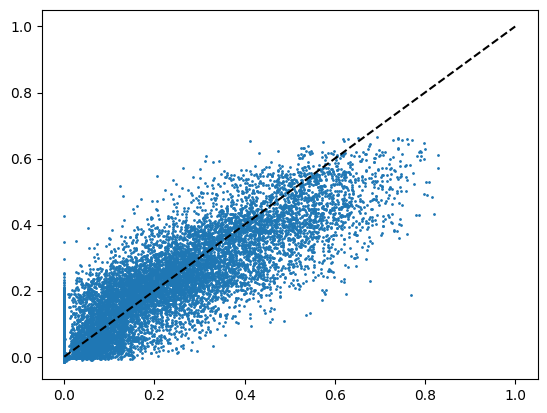

In [8]:
plt.scatter(y_test[:,0], predictions[:,0], s=1)
plt.plot([0,1],[0,1],'k--')

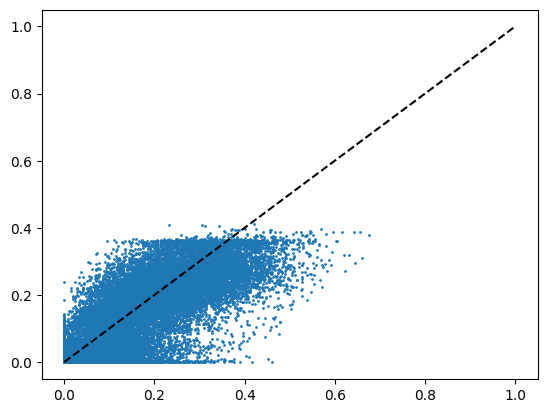

In [9]:
plt.scatter(y_test[:,1], predictions[:,1], s=1)
plt.plot([0,1],[0,1],'k--')

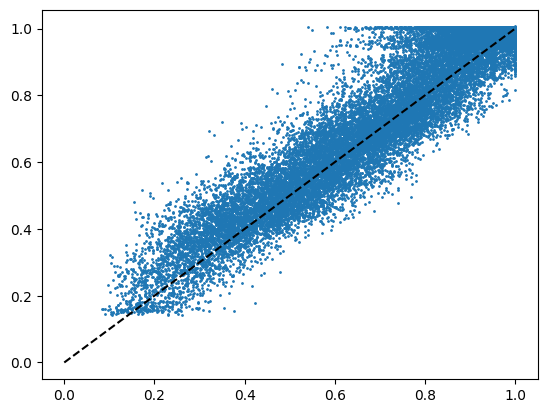

In [10]:
plt.scatter(y_test[:,2], predictions[:,2], s=1)
plt.plot([0,1],[0,1],'k--')

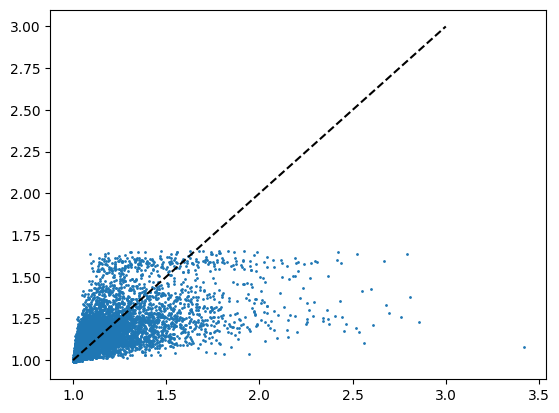

In [11]:
plt.scatter(y_test[:,3], predictions[:,3], s=1)
plt.plot([1,3],[1,3],'k--')

### Load TIGRESS Data and create DataLoader

In [13]:
from pathlib import Path
from astropy.io import fits
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

TIGRESS_data_path = Path('/scratch/mk27/em8117/R8_2pc')

TIGRESS_spectra_file = TIGRESS_data_path / '0300/300_Tb_full.fits' # (v, z, x)
TIGRESS_fcnm_file = TIGRESS_data_path / '0300/300_fcnm_full.fits' # (z, x)
TIGRESS_funm_file = TIGRESS_data_path / '0300/300_funm_full.fits' # (z, x)
TIGRESS_fwnm_file = TIGRESS_data_path / '0300/300_fwnm_full.fits' # (z, x)
TIGRESS_rhi_file = TIGRESS_data_path / '0300/300_rhi_full.fits' # (z, x)

TIGRESS_spectra= fits.getdata(TIGRESS_spectra_file)[:, 1600:1950, :]
TIGRESS_fcnm = fits.getdata(TIGRESS_fcnm_file)[1600:1950, :]
TIGRESS_funm = fits.getdata(TIGRESS_funm_file)[1600:1950, :]
TIGRESS_fwnm = fits.getdata(TIGRESS_fwnm_file)[1600:1950, :]
TIGRESS_rhi = fits.getdata(TIGRESS_rhi_file)[1600:1950, :]

TIGRESS_rhi = np.clip(TIGRESS_rhi, 1, None)

print('Spectra shape:', TIGRESS_spectra.shape)
print('fCNM shape:', TIGRESS_fcnm.shape)
print('fUNM shape:', TIGRESS_funm.shape)
print('fWNM shape:', TIGRESS_fwnm.shape)
print('RHI shape:', TIGRESS_rhi.shape)

print('Preprocessing data...')
TIGRESS_spectra += np.random.randn(*TIGRESS_spectra.shape) * 0.5

TIGRESS_fcnm = TIGRESS_fcnm.flatten()
TIGRESS_funm = TIGRESS_funm.flatten()
TIGRESS_fwnm = TIGRESS_fwnm.flatten()
TIGRESS_rhi = TIGRESS_rhi.flatten()

print('Flattened data shapes:')
print('fCNM:', TIGRESS_fcnm.shape)
print('fUNM:', TIGRESS_funm.shape)
print('fWNM:', TIGRESS_fwnm.shape)
print('RHI:', TIGRESS_rhi.shape)

# Starts as (v, z, x), move to (x, z, v)
TIGRESS_spectra = np.moveaxis(TIGRESS_spectra, 0, -1)
print('Spectra shape after moveaxis:', TIGRESS_spectra.shape)
# Flatten (x, z, v) to (x*z, v)
TIGRESS_spectra = TIGRESS_spectra.reshape(-1, TIGRESS_spectra.shape[-1])
print('Spectra shape after reshape:', TIGRESS_spectra.shape)

# Remove any lines of sight with NaNs or with spectra of all zeros
nanIndices = np.isnan(TIGRESS_spectra).any(axis=1) | np.isnan(TIGRESS_fcnm) | np.isnan(TIGRESS_funm) | np.isnan(TIGRESS_fwnm) | np.isnan(TIGRESS_rhi) | np.all(TIGRESS_spectra == 0, axis=1)# | fwnmData == 1 # Remove lines of sight with fWNM = 1 as they seems to really skew the model
TIGRESS_spectra = TIGRESS_spectra[~nanIndices]
TIGRESS_fcnm = TIGRESS_fcnm[~nanIndices]
TIGRESS_funm = TIGRESS_funm[~nanIndices]
TIGRESS_fwnm = TIGRESS_fwnm[~nanIndices]
TIGRESS_rhi = TIGRESS_rhi[~nanIndices]
los_removed = np.sum(nanIndices)
print(f'Removed {los_removed} lines of sight with NaNs')

TIGRESS_targets = np.stack((TIGRESS_fcnm, TIGRESS_funm, TIGRESS_fwnm, TIGRESS_rhi), axis=1) # Axis 1 because we want (x*z, 4)

TIGRESS_dataset = TensorDataset(Tensor(TIGRESS_spectra+0).to('cuda'), Tensor(TIGRESS_targets+0).to('cuda'))

TIGRESS_data_loader = DataLoader(TIGRESS_dataset, batch_size=32, shuffle=False)


Spectra shape: (256, 350, 512)
fCNM shape: (350, 512)
fUNM shape: (350, 512)
fWNM shape: (350, 512)
RHI shape: (350, 512)
Preprocessing data...
Flattened data shapes:
fCNM: (179200,)
fUNM: (179200,)
fWNM: (179200,)
RHI: (179200,)
Spectra shape after moveaxis: (350, 512, 256)
Spectra shape after reshape: (179200, 256)
Removed 0 lines of sight with NaNs


In [15]:
TIGRESS_predictions = model.predict(TIGRESS_data_loader).cpu().numpy()
TIGRESS_predictions = TIGRESS_predictions.reshape(1, 350, 512, 4)
TIGRESS_predictions.shape

(1, 350, 512, 4)

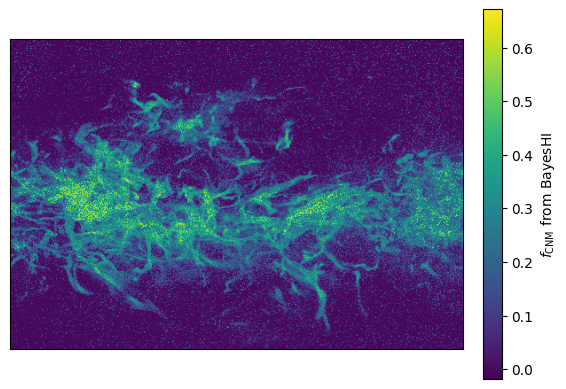

In [16]:
plt.imshow(TIGRESS_predictions[0,:,:,0], origin='lower')
plt.colorbar(label=r'$f_\text{CNM}$ from BayesHI',fraction=0.046, pad=0.04)
plt.yticks([])
plt.xticks([])
plt.show()

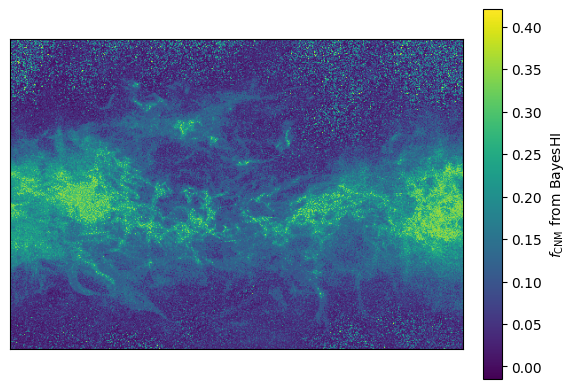

In [17]:
plt.imshow(TIGRESS_predictions[0,:,:,1], origin='lower')
plt.colorbar(label=r'$f_\text{CNM}$ from BayesHI',fraction=0.046, pad=0.04)
plt.yticks([])
plt.xticks([])
plt.show()

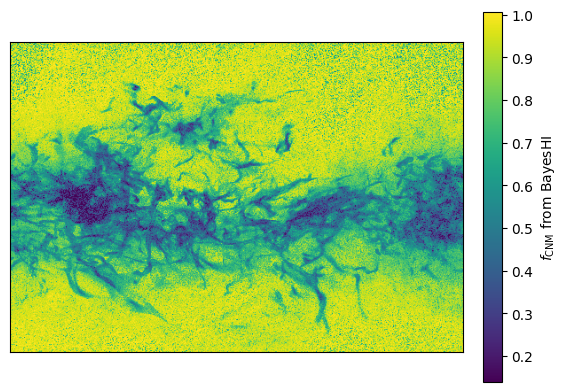

In [18]:
plt.imshow(TIGRESS_predictions[0,:,:,2], origin='lower')
plt.colorbar(label=r'$f_\text{CNM}$ from BayesHI',fraction=0.046, pad=0.04)
plt.yticks([])
plt.xticks([])
plt.show()

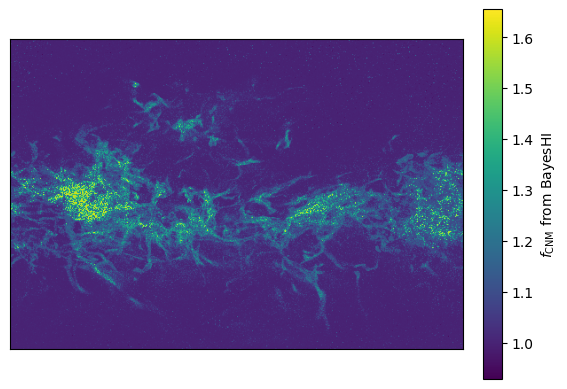

In [19]:
plt.imshow(TIGRESS_predictions[0,:,:,3], origin='lower')
plt.colorbar(label=r'$f_\text{CNM}$ from BayesHI',fraction=0.046, pad=0.04)
plt.yticks([])
plt.xticks([])
plt.show()

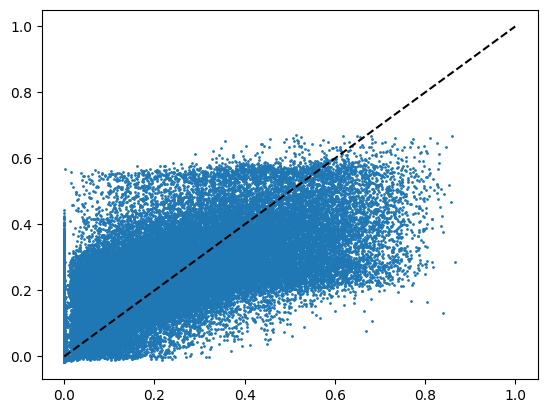

In [20]:
plt.scatter(TIGRESS_targets[:,0], TIGRESS_predictions[0,:,:,0], s=1)
plt.plot([0,1],[0,1],'k--')

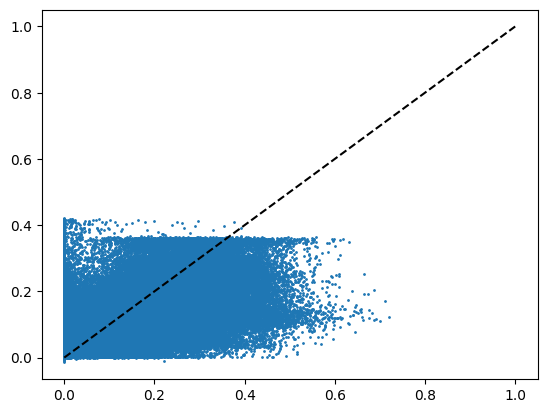

In [21]:
plt.scatter(TIGRESS_targets[:,1], TIGRESS_predictions[0,:,:,1], s=1)
plt.plot([0,1],[0,1],'k--')

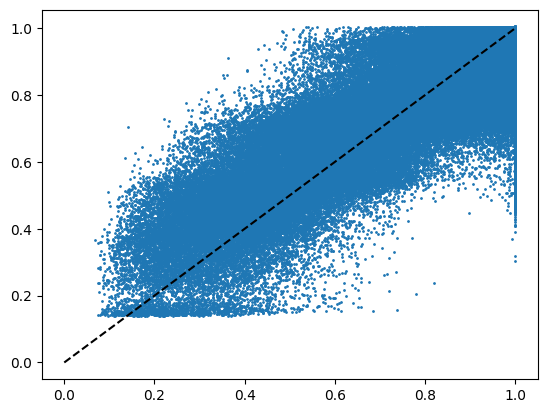

In [22]:
plt.scatter(TIGRESS_targets[:,2], TIGRESS_predictions[0,:,:,2], s=1)
plt.plot([0,1],[0,1],'k--')

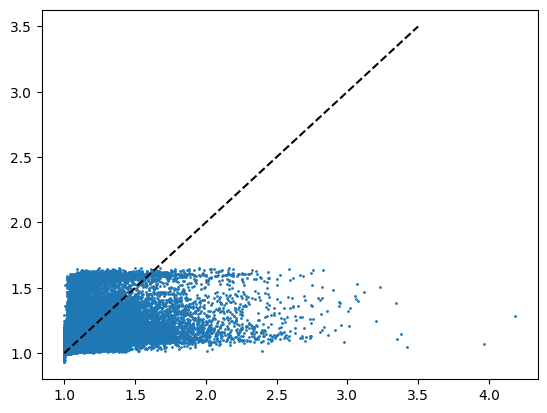

In [23]:
plt.scatter(TIGRESS_targets[:,3], TIGRESS_predictions[0,:,:,3], s=1)
plt.plot([1,3.5],[1,3.5],'k--')